---
# Fit eines Intensitätsspektrums (Beispiel)
---

Die kommenden Zellen zeigen ein Beispiel zur Durchführung einer Beispielaufgabe zur Anpassung eines Intensitätsspektrums. 

## 0. Laden der Erforderlichen Pakete

Standard Schritt eines jeden Notebooks. Einfügen aller benötigten Pakete am Anfang des Dokuments. Alle zur Verfügung stehenden Pakete sind in *requirments.txt* gespeichert. Solltest du das Notebook lokal austesten wollen (ohne virtuelle Umgebung), dann müssen die Pakete bei dir installiert sein.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

import PhyPraKit as ppk
from kafe2 import XYContainer, Fit, Plot

## 1. Erstellung der Daten
Du du besondere Wünsche bei der Erstellung der Daten hattest, musste ich etwas tricksen. <br>
**Prinzipielles Vorgehen:**
1. Würfeln von Zufallsereignissen gemäß der Cauchy Verteilung
2. Histogrammieren der Daten
3. Histogramm Einträge und Binmitten bestimmen aus Histogramm

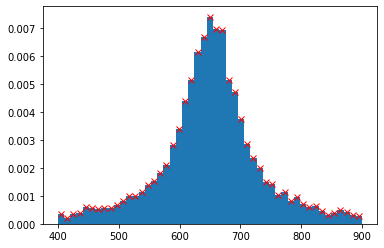

In [4]:
# generation of random data and truncate distribution
wl_true = cauchy.rvs(loc=650, scale=50, size=10000)
wl_true = wl_true[(wl_true>400) & (wl_true<900)]

# set binning to desired space and give bin number
bins = np.linspace(400, 900, 50) # (beginn, end, size)

# histogramm data to get intensity and wavelengths for intensity for save and check data
intensity, edges, _ = plt.hist(wl_true, bins=bins, density=True)

wavelength = (edges[1:]+edges[:-1]) / 2

plt.plot(wavelength, intensity, "rx")

plt.show()

## 2. Speichern der Daten
Sobald du mit den Daten zufrieden bist, kannst du diese auch speichern. Deine Schüler müssen niemals erfahren, dass du die Daten nicht wirklich selbst erstellt hast. <br>
*Hinweis: Sobald du einmal mit einem Datensatz zufrieden bist, kannst du Schritt 1 und 2 überspringen.*

In [5]:
# write data to file
ppk.writeCSV("Intensitaetsmessung.csv", [wavelength, intensity], hlines=["Wellenlänge in nm, Intensität"])

0

## 3. Einlesen der Daten
Das musst du deinen Schüler zeigen. Ich hab hier die Einlesefunktion von *PhyPraKit* verwendet, aber andere *Python* Pakete können genau das gleiche erzielen. (*Beispiel: numpy.loadtxt(), pandas.read_csv()*)

In [6]:
# read data from file
head, data = ppk.readCSV("Intensitaetsmessung.csv")
wavelength, intensity = data

## 4. Erstellung des Fits
Jetzt kommt der etwas anstrengende Part: der Fit selbst. Ich habe hier *kafe2* verwendet, da man viele Optionen hat, um selbst daran rum zu spielen. Gleichzeitig ist die Struktur aber auch so einfach, dass man den Prozess in drei bis vier Schritte unterteilen kann.

Zunächst definierst du dir das gesuchte Modell. Ich habe heir die standardmäßige Cauchy Verteilung gewählt. Der sogennnte *Doc-String* (Bereich zwischen den """) ist nicht unbedingt notwenig und kann/sollte für die Schüler gegebenfalls weggelassen werden.

In [7]:
# define model
def Cauchy(x, x_0, gamma):
    """
    Normed chauchy distribution
    :x: data
    :x_0: location
    :gmma: scale
    """
    return  (gamma**2 / ((x - x_0)**2 + gamma**2)) / (np.pi * gamma)

Jetzt kommen wir zum spaßigen Teil der Anwendung. Das einfache Interface von *kafe2* kann in **drei** Strukturen unterteilt werden. Die Strukturen sind *Python* Klassen und weisen somit Attribute und Module auf. Attribute sind in der Klasse gespeicherte Variablen, während Module meist nur eine Funktion beinhalten. Manchmal werden Module auch dazu verwendet kompliziertere Variablen innerhalb der Klasse zu setzen. Die hier verwendeten Strukturen sind:
- Datenstruktur: *XYContainer(x_data, y_data)*
- Fitstruktur: *Fit(data, model_function, minimizer)*
- Plotstruktur: *Plot(fit_objects)*
Die Verwendung der Strukturen ist immer gleich. Zunächst initialisierst du die Struktur und dann manipulierst du sie. Also einmal musst du das Objekt erstellen, indem du die Struktur mit den richtigen Paramtern aufrufst. Danach machst du gegebenfalls Anpassungen und lässt dann ggf. die Aufgabe der Struktur laufen.

Eine kleine Zusammenfassung von dem was ich gemacht habe:
- Daten
    - Einlesen
    - *x* und *y* Labels setzen für den Plot
    - Anschauliche Fehler für die *x* und *y* Werte angegeben, wenn das nicht gesetzt wird, wird der Fehler mit 1 angenommen
- Fit
    - Fit aufgerufen mit dem *iminuit* Minimierer (läuft zuverlässiger)
    - Weitere Plot Verschönerungen vorgenommen (*assign_model_function_latex_expression* ist ziemlich zickig)
    - Untere Grenze für die gesuchten Parameter definiert. Ist nicht unbedingt notwendig und für $x_0$ streng genommen nicht allgemein, aber es beschleunigt den Fit allgemein.
    - Startwerte für $x_0$ und $\gamma$ ausgewählt (hilft auch viel für den Fit) 
    - Fit durchgeführt und die Fitwerte für die Parameter in *x0* und *g* gespeichert
- Plot
    - Vorbereitet und durchgeführt

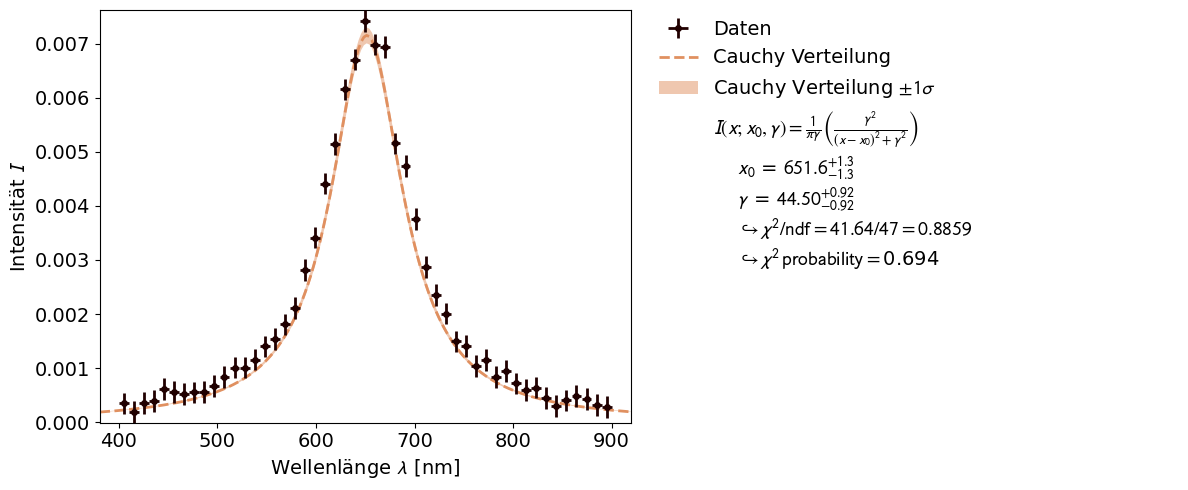

In [25]:
# prepare data
xy_data = XYContainer(wavelength, intensity)

# costumize output
xy_data.axis_labels = ["Wellenlänge $\\lambda$ [nm]", "Intensität $I$"]

# add realistic errors
xy_data.add_error("x", 5)
xy_data.add_error("y", 0.0002)

# prepare fit
fit = Fit(xy_data, Cauchy, minimizer="iminuit")

# costumize fit output
fit.assign_model_function_latex_name('I')
fit.assign_model_function_latex_expression(
    r"\frac{{1}}{{\pi\gamma}}\left(\frac{{\gamma^2}}{{({x}-{x_0})^2+\gamma^2}}\right)"
)
fit.data_container.label = "Daten"
fit.model_label = "Cauchy Verteilung"

# constrain data to be positive
eps = 1e-8
fit.limit_parameter('x_0', lower=eps)
fit.limit_parameter('gamma', lower=eps)

# set initial values (good guess)
fit.set_parameter_values(x_0=650, gamma=50)

# perform fit
results = fit.do_fit()
x0, g = results["parameter_values"].values()

# prepare plot
plot = Plot(fit)

# perform plot
# asymmetric_parameter_errors will show asymmetric errors
plot.plot(asymmetric_parameter_errors=True)
plt.show()